In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import seaborn as sns

In [ ]:
messages = pd.read_csv('/content/drive/My Drive/dataset/SMSSpamCollection', sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
messages.info()
messages.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [ ]:
messages["Length"] = messages["message"].apply(len)
messages.head(2)

,label,message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


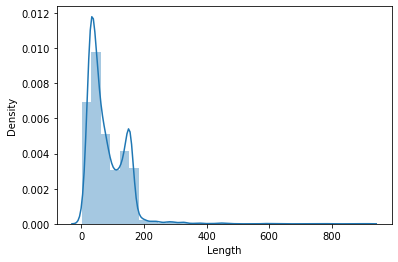

In [ ]:
sns.distplot(messages["Length"], bins=30)

In [ ]:
messages["Length"].max()

910

In [ ]:
messages[messages["Length"] == messages["Length"].min()]["message"].iloc[0]

'Ok'

In [ ]:
X=messages.message
from tensorflow.keras.utils import to_categorical #one hot
labels = [1 if x == "spam" else 0 for x in messages['label'].values]
labels = to_categorical(labels)
labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

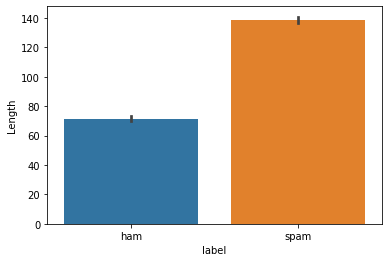

In [ ]:
sns.barplot(x='label', y='Length', data=messages)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd21ed62e50>,
      dtype=object)

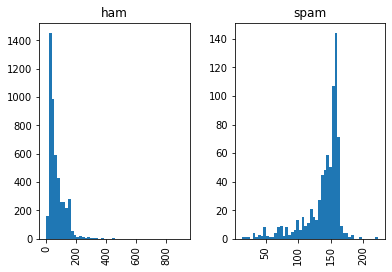

In [ ]:
messages.hist(column='Length',by='label', bins=50)

In [ ]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: message, Length: 5572, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense, Input, Embedding, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_NUMBER_OF_WORDS = 10000
MAX_SEQ_LEN = 70
max_features = 10000
embedding_size = 128
tokenizer = Tokenizer(num_words=MAX_NUMBER_OF_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X,)
matrix = pad_sequences(sequences, maxlen=MAX_SEQ_LEN) #pre 
matrix

array([[   0,    0,    0, ...,   58, 4437,  144],
       [   0,    0,    0, ...,  472,    6, 1940],
       [   0,    0,    0, ...,  660,  392, 2998],
       ...,
       [   0,    0,    0, ...,  107,  251, 9008],
       [   0,    0,    0, ...,  200,   12,   47],
       [   0,    0,    0, ...,    2,   61,  268]], dtype=int32)

In [ ]:
len(tokenizer.word_index)

9009

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(matrix,labels,test_size=0.20,random_state=25)

In [ ]:
from keras.models import Sequential #lft to rgt or rgt to lft
model = Sequential()
model.add(Embedding(input_dim=9010,output_dim= embedding_size, input_length=MAX_SEQ_LEN,))      #128*9010
model.add(Conv1D(filters=128,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1))                       #128*128*3
model.add(MaxPooling1D(5)) #best features
model.add(Flatten())
model.add(Dense(256,activation = 'relu')) 
model.add(Dense(2,activation = 'softmax')) #2->spam, ham
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.build(X_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 128)           1153280   
_________________________________________________________________
conv1d (Conv1D)              (None, 68, 128)           49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 1,629,314
Trainable params: 1,629,314
Non-trainable params: 0
______________________________________________

In [ ]:
model.fit(X_train,Y_train,batch_size=100,epochs=5, verbose=1) #iteration=5572(80/100) ->xtrain

Epoch 1/5
45/45 [==============================] - 46s 24ms/step - loss: 0.3804 - accuracy: 0.8057
Epoch 2/5
45/45 [==============================] - 1s 14ms/step - loss: 0.0646 - accuracy: 0.9819
Epoch 3/5
45/45 [==============================] - 1s 14ms/step - loss: 0.0185 - accuracy: 0.9934
Epoch 4/5
45/45 [==============================] - 1s 13ms/step - loss: 0.0047 - accuracy: 0.9990
Epoch 5/5
45/45 [==============================] - 1s 14ms/step - loss: 0.0043 - accuracy: 0.9994


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 128)           1153280   
_________________________________________________________________
conv1d (Conv1D)              (None, 68, 128)           49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 1,629,314
Trainable params: 1,629,314
Non-trainable params: 0
______________________________________________

In [ ]:
model.evaluate(X_test,Y_test) #loss, acc

35/35 [==============================] - 1s 6ms/step - loss: 0.0522 - accuracy: 0.9892


[0.05224214866757393, 0.9892376661300659]

In [ ]:
preds = model.predict(X_test)
for i in range(len(preds)):
    if (preds[i][0]>=preds[i][1]):
        x = preds[i][0]
    else:
        x = preds[i][1]
    if preds[i][0]==x:
        preds[i][0]=1 #spam
        preds[i][1]=0
    elif preds[i][1]==x:
        preds[i][0]=0
        preds[i][1]=1 #spam

Y_test_bin=np.argmax(Y_test, axis=1)
pred_bin=np.argmax(preds, axis=1)
pred_bin
Y_test_bin

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
preds = model.predict(X_test)
preds

array([[7.4485938e-06, 9.9999261e-01],
       [9.9999464e-01, 5.4001580e-06],
       [9.9952722e-01, 4.7274714e-04],
       ...,
       [9.9999189e-01, 8.0760410e-06],
       [1.0000000e+00, 4.3746478e-08],
       [9.9994457e-01, 5.5399731e-05]], dtype=float32)

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
conf = confusion_matrix(Y_test_bin, pred_bin)
print(conf)
print('----------------------------------------------------')
print(classification_report(Y_test_bin, pred_bin))
print('----------------------------------------------------')

Confusion Matrix
[[957   1]
 [ 11 146]]
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       958
           1       0.99      0.93      0.96       157

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115

----------------------------------------------------


Glove


In [ ]:
from keras.layers import Embedding
import os
EMBEDDING_DIM = 100
# map word to embedding
embeddings_index = {}
for line in open(os.path.join('/content/drive/My Drive/dataset/glove.6B', 'glove.6B.100d.txt')):
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')

In [ ]:
tokenizer2 = Tokenizer(num_words=MAX_NUMBER_OF_WORDS)
tokenizer2.fit_on_texts(X)
sequences = tokenizer2.texts_to_sequences(X)
vocabsize = len(tokenizer2.word_index) + 1
matrix = np.zeros((vocabsize, EMBEDDING_DIM)) #vocabsizex100

for word, i in tokenizer2.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(vocabsize,
                            EMBEDDING_DIM,
                            weights=[matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=False)
from keras.models import Sequential
model = Sequential()
model.add(embedding_layer) 
model.add(Conv1D(filters=128,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(2,activation = 'softmax'))
#model.build(X_train.shape)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 70, 100)           901000    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 68, 128)           38528     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 1664)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               426240    
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 514       
Total params: 1,366,282
Trainable params: 465,282
Non-trainable params: 901,000
_______________________________________

In [ ]:
model.fit(X_train,Y_train,batch_size=100,epochs=5, verbose=1)

Epoch 1/5
45/45 [==============================] - 1s 9ms/step - loss: 0.0294 - accuracy: 0.9904
Epoch 2/5
45/45 [==============================] - 0s 5ms/step - loss: 0.0247 - accuracy: 0.9930
Epoch 3/5
45/45 [==============================] - 0s 5ms/step - loss: 0.0177 - accuracy: 0.9951
Epoch 4/5
45/45 [==============================] - 0s 5ms/step - loss: 0.0264 - accuracy: 0.9906
Epoch 5/5
45/45 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 0.9980


In [ ]:
preds = model.predict(X_test)
for i in range(len(preds)):
    if(preds[i][0]>=preds[i][1]):
        x = preds[i][0]
    else:
        x = preds[i][1]
    if preds[i][0]==x:
        preds[i][0]=1
        preds[i][1]=0
    elif preds[i][1]==x:
        preds[i][0]=0
        preds[i][1]=1

Y_test_bin=np.argmax(Y_test, axis=1)
pred_bin=np.argmax(preds, axis=1)

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
conf = confusion_matrix(Y_test_bin, pred_bin)
print(conf)
print('----------------------------------------------------')
print(classification_report(Y_test_bin, pred_bin))
print('----------------------------------------------------')

Confusion Matrix
[[957   1]
 [ 14 143]]
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       958
           1       0.99      0.91      0.95       157

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

----------------------------------------------------
